#### 5 year Forecasting With Online Sales


In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
import pyodbc 
import pandas as pd
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-4P75PCB;'
                      'Database=AdventureWorks2012;' 
                      'Trusted_Connection=yes;')


sql_for_df1 = """SELECT SOH.[OrderDate],CASE WHEN SOH.[OnlineOrderFlag] = 1 THEN 'Online' ELSE 'Reseller' END AS Sales_Channel,
                SO.[OrderQty]*SO.[UnitPrice] AS Total_Sales,
                ST.Name AS Region 
                FROM [Sales].[SalesOrderDetail] AS SO \
                INNER JOIN [Sales].[SalesOrderHeader] AS SOH \
                ON SO.SalesOrderID = SOH.SalesOrderID \
                INNER JOIN [Production].[Product] AS PP \
                ON SO.[ProductID] = PP.ProductID \
                INNER JOIN  [Production].[ProductSubcategory] AS PSC \
                ON PP.[ProductSubcategoryID] = PSC.[ProductSubcategoryID] \
                INNER JOIN [Production].[ProductCategory] AS PC \
                ON PSC.[ProductCategoryID] = PC.[ProductCategoryID] \
                INNER JOIN [Sales].[SalesTerritory] AS ST \
                ON ST.TerritoryID =SOH.TerritoryID \
                WHERE OnlineOrderFlag = '1' """

df = pd.read_sql(sql_for_df1 , conn)


conn.close()
df.head()

,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia


In [3]:
df = pd.DataFrame(df)
df.reset_index(drop=True, inplace=True)
df


,OrderDate,Sales_Channel,Total_Sales,Region
0,2011-05-31,Online,3578.2700,Canada
1,2011-05-31,Online,3399.9900,France
2,2011-05-31,Online,3399.9900,Northwest
3,2011-05-31,Online,699.0982,Southwest
4,2011-05-31,Online,3399.9900,Australia
...,...,...,...,...
60393,2014-06-30,Online,21.9800,Canada
60394,2014-06-30,Online,8.9900,Canada
60395,2014-06-30,Online,21.9800,Canada
60396,2014-06-30,Online,159.0000,Canada


In [4]:
df.OrderDate.max() 

Timestamp('2014-06-30 00:00:00')

In [5]:
df.OrderDate.min()

Timestamp('2011-05-31 00:00:00')

In [82]:
#df['OrderDate']=pd.to_datetime(df['OrderDate'])

In [8]:
online_channel= df.loc[df['Region'] == 'Northwest',:]
online_channel

,OrderDate,Sales_Channel,Total_Sales,Region
2,2011-05-31,Online,3399.9900,Northwest
14,2011-06-03,Online,3578.2700,Northwest
21,2011-06-05,Online,3578.2700,Northwest
26,2011-06-06,Online,699.0982,Northwest
36,2011-06-08,Online,3578.2700,Northwest
...,...,...,...,...
60356,2014-06-30,Online,21.9800,Northwest
60357,2014-06-30,Online,34.9900,Northwest
60384,2014-06-30,Online,4.9900,Northwest
60385,2014-06-30,Online,35.0000,Northwest


### Data Preprocessing

In [9]:
cols = ['Sales_Channel','Region']
online_channel.drop(cols, axis=1, inplace=True)
online_channel = online_channel.sort_values('OrderDate')
online_channel.isnull().sum()


OrderDate      0
Total_Sales    0
dtype: int64

In [10]:
online_channel = online_channel.groupby('OrderDate')['Total_Sales'].sum().reset_index()
online_channel

,OrderDate,Total_Sales
0,2011-05-31,3399.9900
1,2011-06-03,3578.2700
2,2011-06-05,3578.2700
3,2011-06-06,699.0982
4,2011-06-08,3578.2700
...,...,...
810,2014-06-26,235.6800
811,2014-06-27,186.9200
812,2014-06-28,89.9600
813,2014-06-29,520.2200


### Indexing with Time Series Data

In [11]:
online_channel = online_channel.set_index('OrderDate')
online_channel.index

DatetimeIndex(['2011-05-31', '2011-06-03', '2011-06-05', '2011-06-06',
               '2011-06-08', '2011-06-09', '2011-06-11', '2011-06-13',
               '2011-06-14', '2011-06-18',
               ...
               '2014-06-21', '2014-06-22', '2014-06-23', '2014-06-24',
               '2014-06-25', '2014-06-26', '2014-06-27', '2014-06-28',
               '2014-06-29', '2014-06-30'],
              dtype='datetime64[ns]', name='OrderDate', length=815, freq=None)

current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [12]:
y = online_channel['Total_Sales'].resample('MS').mean()
y = y.fillna(y.bfill())

In [18]:
y['2014':]

OrderDate
2014-01-01    6781.100968
2014-02-01    6278.014286
2014-03-01    6065.280645
2014-04-01    6881.717000
2014-05-01    8465.397419
2014-06-01     143.791379
Freq: MS, Name: Total_Sales, dtype: float64

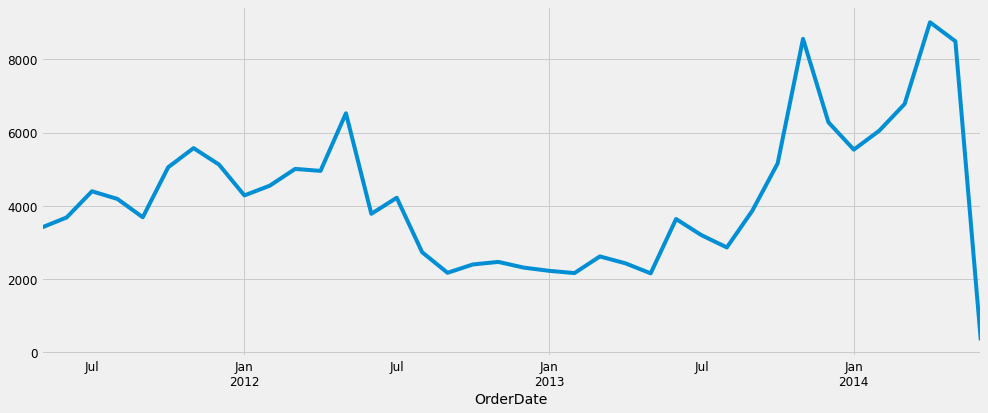

In [13]:
#Visualizing Country Sales Time Series Data
y.plot(figsize=(15, 6))
plt.show()

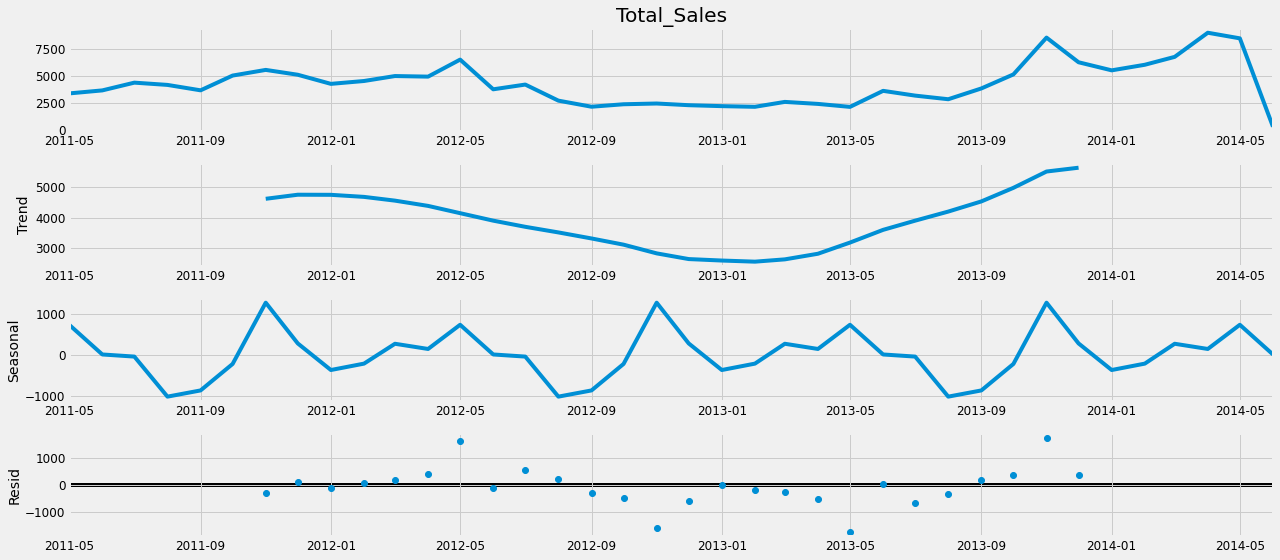

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

### Time series forecasting with ARIMA
We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [16]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:732.7706703286791
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1119.043415995585
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:478.08389099465717
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:253.53020243953293
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:498.5247464394346
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1101.2478696841156
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:248.0794402690768
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:231.11348523468988
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:678.8287088420885
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2188.6270200878093
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:447.6324845593473
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:229.2916112208489
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:481.93762031312895
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2724.7888190611584
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:249.01398296156836
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:215.65138871697263
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:642.5865197802618
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1451.7604527506514


 ### Fitting an ARIMA Time Series Model

In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2574      1.327     -0.194      0.846      -2.858       2.343
ma.L1         -0.1833      1.178     -0.156      0.876      -2.492       2.125
ar.S.L12      -2.0681      0.362     -5.709      0.000      -2.778      -1.358
ma.S.L12       1.1206      0.754      1.487      0.137      -0.356       2.598
sigma2      1.374e+06   6.45e-07   2.13e+12      0.000    1.37e+06    1.37e+06


### Validating forecasts

In [18]:
#pred = results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False)
pred = results.get_prediction(start=pd.to_datetime('2011-06-01'), end=pd.to_datetime('2014-06-30 05:40:00'),dynamic=True, full_results=True)
pred_ci = pred.conf_int()


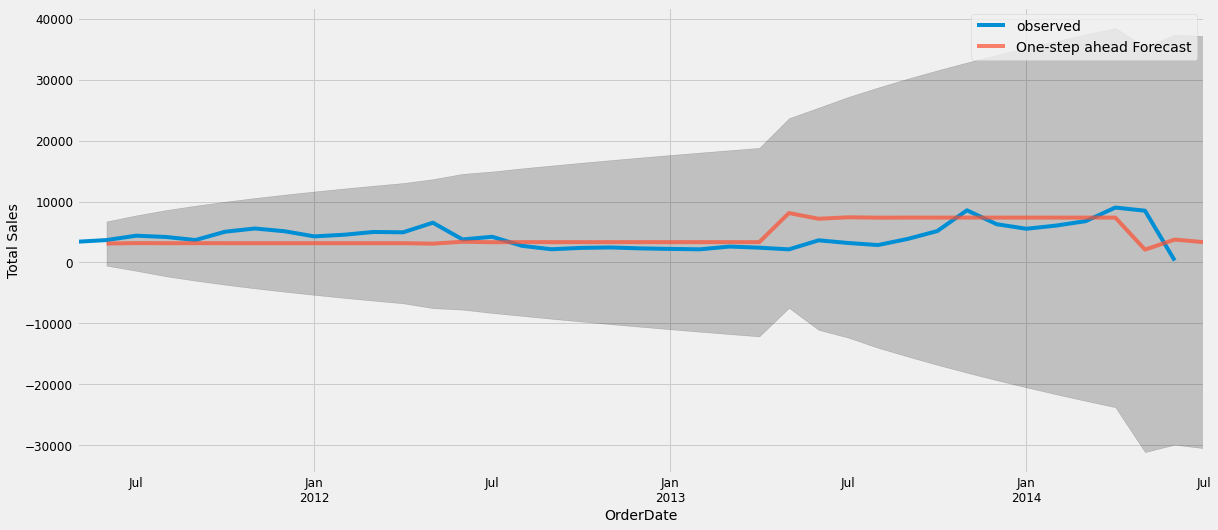

In [19]:
ax = y['2011':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()

plt.show()

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2014-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 10111108.14


In [21]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 3179.8


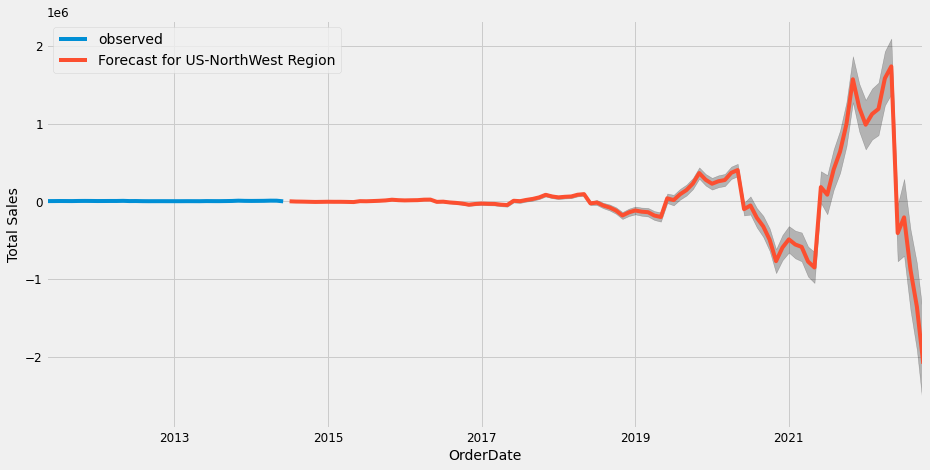

In [23]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast for US-NorthWest Region')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('OrderDate')
ax.set_ylabel('Total Sales')
plt.legend()
plt.show()